In [9]:
%matplotlib inline
import os
import glob
import datetime as dt
import numpy as np
import platform
from cartopy import crs as ccrs
from matplotlib import pyplot as plt
from mintpy.utils import ptime, readfile, writefile, isce_utils, utils as ut, plot as pp
from mintpy.cli import geocode, load_data, multilook, smallbaselineApp, view
plt.rcParams.update({'font.size': 12})

# platform
if platform.system() == 'Linux':
    proj_dir = os.path.expanduser('~/data/2024NotoEQ')
else:
    proj_dir = os.path.expanduser('~/data/archives/2024NotoEQ')

# dataset
ds_name = [
    'ALOS2_A121_20220926_20240101_IFG',   # 0
    'ALOS2_D026_20230606_20240102_IFG',   # 1
    'ALOS2_A127_20231206_20240103_IFG',   # 2
    'ALOS2_A128_20230612_20240108_IFG',   # 3
    'ALOS2_D019_20211019_20240109_IFG',   # 4
][4]
redo = True

work_dir = os.path.join(proj_dir, ds_name[:-4], 'insar')
os.chdir(work_dir)
print('Go to directory:', work_dir)

# input files
lks = '32rlks_40alks'
date1, date2 = ptime.yymmdd(ds_name.split('_')[2:4])
int_file = f'filt_{date1}-{date2}_{lks}.int'
unw_file = f'filt_{date1}-{date2}_{lks}.unw'
cor_file = f'{date1}-{date2}_{lks}.phsig'

# output grid
S, N, W, E = 36.7, 37.6, 136.6, 137.45 # 36.57, 37.61, 136.57, 137.50  #

# output files
geom_file = os.path.join(work_dir, 'inputs/geometryRadar.h5')

Go to directory: /home/yunjunz/data/2024NotoEQ/ALOS2_D019_20211019_20240109/insar


In [10]:
config = {
    'ALOS2_A121_20220926_20240101_IFG': {'ymin':800, 'ymax':2200},
    'ALOS2_D026_20230606_20240102_IFG': {'ymin':500,  'ymax':2000},
    'ALOS2_A127_20231206_20240103_IFG': {'ymin':500,  'ymax':2000},
    'ALOS2_A128_20230612_20240108_IFG': {'ymin':0,    'ymax':1400},
    'ALOS2_D019_20211019_20240109_IFG': {'ymin':700,  'ymax':2200},
}[ds_name]
ymin, ymax = config['ymin'], config['ymax']

run view.py in MintPy version 1.6.0.post6, date 2024-05-20
input file is isce .int file: /panda/yunjunz/2024NotoEQ/ALOS2_D019_20211019_20240109/insar/filt_211019-240109_32rlks_40alks.int in complex64 format
file size in y/x: (2109, 813)
input dataset: "['phase']"
num of datasets in file filt_211019-240109_32rlks_40alks.int: 2
datasets to exclude (0):
[]
datasets to display (1):
['phase']
data   coverage in y/x: (0, 0, 813, 2109)
subset coverage in y/x: (0, 0, 813, 2109)
data   coverage in lat/lon: None
subset coverage in lat/lon: None
------------------------------------------------------------------------
colormap: cmy
figure title: filt_211019-240109_32rlks_40alks.int
figure size : [3.9, 8.0]
reading data ...
data    range: [-3.1415863, 3.1415918] radian
display range: [-3.141592653589793, 3.141592653589793] radian
display data in transparency: 1.0
plotting in Y/X coordinate ...
plotting data via matplotlib.pyplot.imshow ...
save figure to /panda/yunjunz/2024NotoEQ/ALOS2_D019_2021101

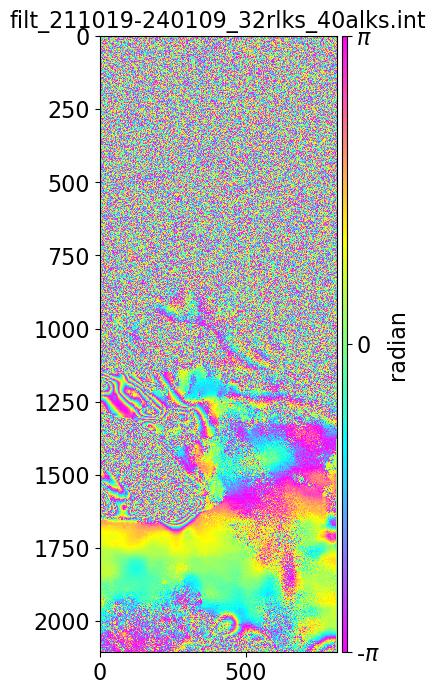

run view.py in MintPy version 1.6.0.post6, date 2024-05-20
input file is isce .phsig file: /panda/yunjunz/2024NotoEQ/ALOS2_D019_20211019_20240109/insar/211019-240109_32rlks_40alks.phsig in float32 format
file size in y/x: (2109, 813)
num of datasets in file 211019-240109_32rlks_40alks.phsig: 1
datasets to exclude (0):
[]
datasets to display (1):
['band1']
data   coverage in y/x: (0, 0, 813, 2109)
subset coverage in y/x: (0, 0, 813, 2109)
data   coverage in lat/lon: None
subset coverage in lat/lon: None
------------------------------------------------------------------------
colormap: gray
figure title: 211019-240109_32rlks_40alks.phsig
figure size : [3.9, 8.0]
reading data ...
data    range: [0.0, 0.99998844] 1
display range: [0.0, 0.99998844] 1
display data in transparency: 1.0
plotting in Y/X coordinate ...
plotting data via matplotlib.pyplot.imshow ...
save figure to /panda/yunjunz/2024NotoEQ/ALOS2_D019_20211019_20240109/insar/211019-240109_32rlks_40alks.phsig.png with dpi=300
showi

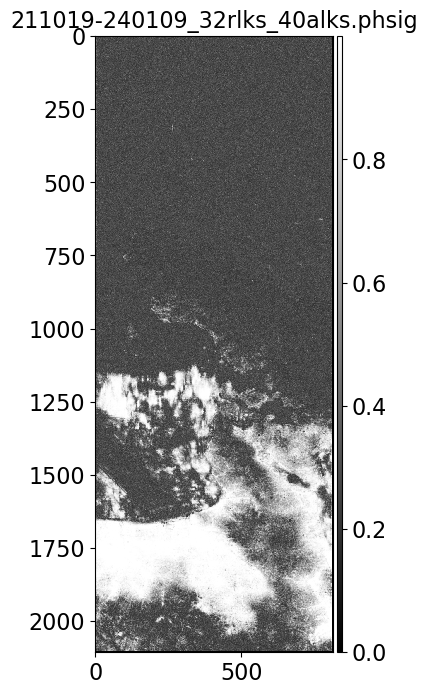

In [11]:
view.main(f'{int_file} phase -c cmy --save --dpi 300'.split())
view.main(f'{cor_file} -c gray --save --dpi 300'.split())

### Geometry

In [12]:
# convert water body into water mask [for mintpy]
cmd = f'generate_mask.py ./{date1}-{date2}_{lks}.wbd --max 0.5 -o ./waterMask.rdr'
!{cmd}

input .wbd file: ./211019-240109_32rlks_40alks.wbd
read ./211019-240109_32rlks_40alks.wbd
create initial mask with the same size as the input file and all = 1
all pixels with nan value = 0
exclude pixels with value > 0.5
write file: ./waterMask.rdr
write file: ./waterMask.rdr.rsc
time used: 00 mins 0.1 secs.


In [13]:
# write geometry HDF5 file
config_str = f"""# vim: set filetype=cfg:
########## 1. Load Data (--load to exit after this step)
## load_data.py -H to check more details and example inputs.
mintpy.load.processor        = isce
##---------for ISCE only:
mintpy.load.metaFile         = ../{date2}.track.xml
mintpy.load.baselineDir      = None
##---------geometry datasets:
mintpy.load.demFile          = ./{date1}-{date2}_{lks}.hgt
mintpy.load.lookupYFile      = ./{date1}-{date2}_{lks}.lat
mintpy.load.lookupXFile      = ./{date1}-{date2}_{lks}.lon
mintpy.load.incAngleFile     = ./{date1}-{date2}_{lks}.los
mintpy.load.azAngleFile      = ./{date1}-{date2}_{lks}.los
mintpy.load.waterMaskFile    = ./waterMask.rdr
"""
sname, oname = ds_name.split('_')[:2]
config_file = os.path.join(work_dir, f'{sname}_{oname}.txt')
print('write MintPy configuration to file: {}'.format(config_file))
with open(config_file, "w") as fid:
    fid.write(config_str)
smallbaselineApp.main(f'{config_file} -g'.split())
# write geometryRadar.h5
load_data.main(f'-t smallbaselineApp.cfg --geom'.split())

write MintPy configuration to file: /home/yunjunz/data/2024NotoEQ/ALOS2_D019_20211019_20240109/insar/ALOS2_D019.txt
--------------------------------------------------
Project name: ALOS2_D019
Go to work directory: /panda/yunjunz/2024NotoEQ/ALOS2_D019_20211019_20240109/insar
read custom template file: /home/yunjunz/data/2024NotoEQ/ALOS2_D019_20211019_20240109/insar/ALOS2_D019.txt
update default template based on input custom template
No new option value found, skip updating /panda/yunjunz/2024NotoEQ/ALOS2_D019_20211019_20240109/insar/smallbaselineApp.cfg
copy ALOS2_D019.txt       to inputs   directory for backup.
copy ALOS2_D019.txt       to pic      directory for backup.
read default template file: /panda/yunjunz/2024NotoEQ/ALOS2_D019_20211019_20240109/insar/smallbaselineApp.cfg
Go back to directory: /panda/yunjunz/2024NotoEQ/ALOS2_D019_20211019_20240109/insar

################################################
   Normal end of smallbaselineApp processing!
###############################

/home/yunjunz/tools/MintPy/src/mintpy/load_data.py:707: UserWarning: prep_isce.py failed. Assuming its result exists and continue...
  warnings.warn('prep_isce.py failed. Assuming its result exists and continue...')


In [14]:
# grab the spatial resolution in meters
meta = readfile.read_attribute(geom_file)
inc_angle_c = float(meta['CENTER_INCIDENCE_ANGLE'])
ystep_m = ut.azimuth_ground_resolution(meta)
xstep_m = ut.range_ground_resolution(meta)
print(f'y/x step: {ystep_m:.1f} / {xstep_m:.1f} m')

# set to the nearest common integer value
step_m = 60 # m, 150 or 60

# convert from meters to degrees
ystep_d = step_m / 108e3
xstep_d = step_m / (108e3 * np.cos(np.deg2rad(inc_angle_c)))
print(f'y/x step [from {step_m} m]: {ystep_d:.8f}, {xstep_d:.8f} deg')

y/x step: 68.9 / 63.9 m
y/x step [from 60 m]: 0.00055556, 0.00079652 deg


### Geocode

geocode.py filt_211019-240109_32rlks_40alks.int -o ./geo/geo_filt_fine.int -l /home/yunjunz/data/2024NotoEQ/ALOS2_D019_20211019_20240109/insar/inputs/geometryRadar.h5 --fill nan --bbox 36.7 37.6 136.6 137.45 --lalo -0.0005555555555555556 0.0007965187747530726
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /home/yunjunz/data/2024NotoEQ/ALOS2_D019_20211019_20240109/insar/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.0005555555555555556, 0.0007965187747530726)
output area extent in (S, N, W, E) in degree: (36.7, 37.6, 136.6, 137.4498855326615)
output file row / column number: (1620, 1067)
[1/1] preparing geometry for dest_box: (0, 0, 1067, 1620) --> full src_box: (0, 0, 813, 2109)
--------------------------------------------------
resampling file: filt_211019-240109_32rlks_40alks.int
--------------------------------------------------1/1
reading complex in block (0, 0, 813, 2109) from filt_211019-

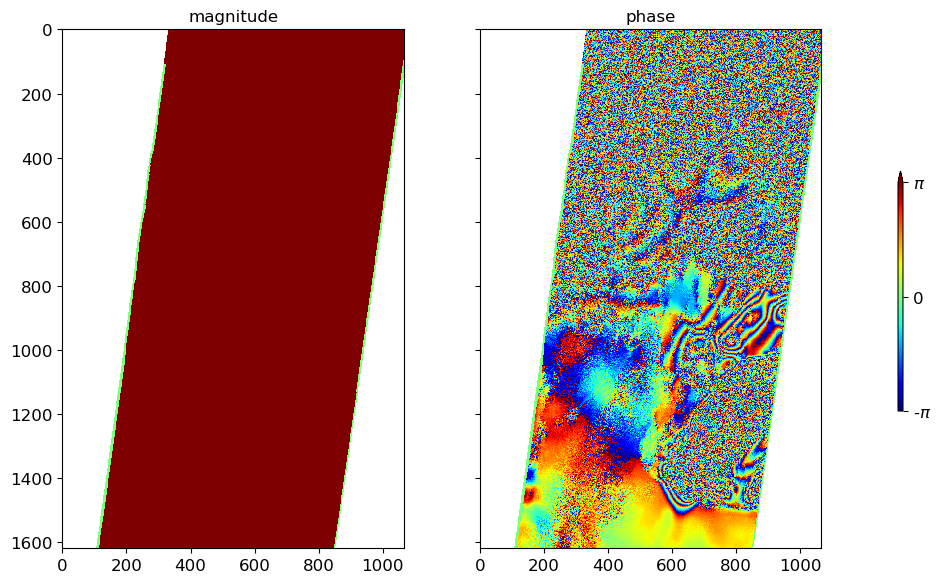

geocode.py filt_211019-240109_32rlks_40alks.unw -o ./geo/geo_filt_fine.unw -l /home/yunjunz/data/2024NotoEQ/ALOS2_D019_20211019_20240109/insar/inputs/geometryRadar.h5 --fill nan --bbox 36.7 37.6 136.6 137.45 --lalo -0.0005555555555555556 0.0007965187747530726
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /home/yunjunz/data/2024NotoEQ/ALOS2_D019_20211019_20240109/insar/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.0005555555555555556, 0.0007965187747530726)
output area extent in (S, N, W, E) in degree: (36.7, 37.6, 136.6, 137.4498855326615)
output file row / column number: (1620, 1067)
[1/1] preparing geometry for dest_box: (0, 0, 1067, 1620) --> full src_box: (0, 0, 813, 2109)
--------------------------------------------------
resampling file: filt_211019-240109_32rlks_40alks.unw
--------------------------------------------------1/1
reading magnitude in block (0, 0, 813, 2109) from filt_21101

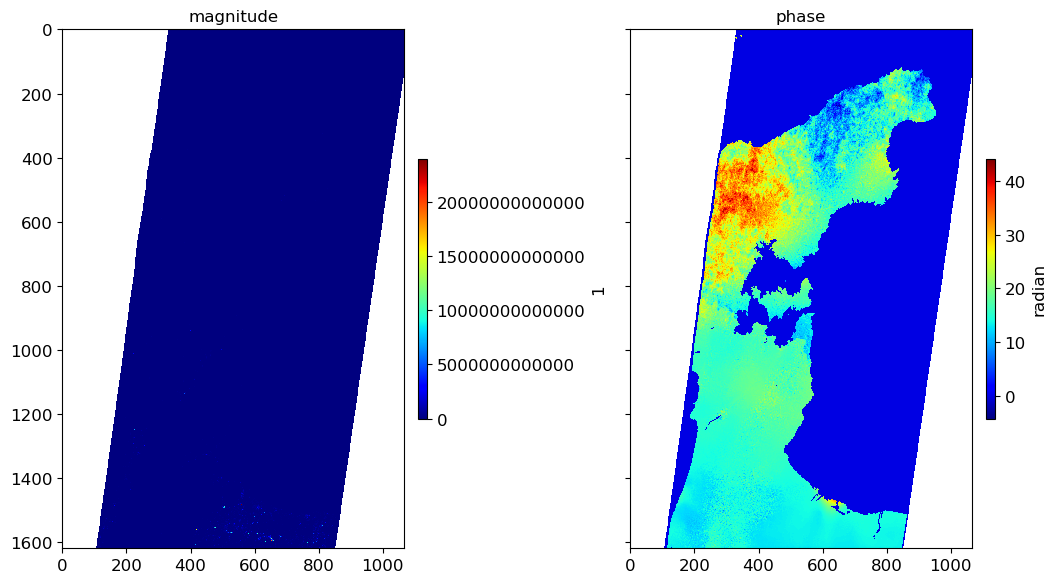

geocode.py 211019-240109_32rlks_40alks.phsig -o ./geo/geo_filt_fine.cor -l /home/yunjunz/data/2024NotoEQ/ALOS2_D019_20211019_20240109/insar/inputs/geometryRadar.h5 --fill nan --bbox 36.7 37.6 136.6 137.45 --lalo -0.0005555555555555556 0.0007965187747530726
number of processor to be used: 1
resampling software: pyresample
read latitude / longitude from lookup table file: /home/yunjunz/data/2024NotoEQ/ALOS2_D019_20211019_20240109/insar/inputs/geometryRadar.h5
output pixel size in (lat, lon) in degree: (-0.0005555555555555556, 0.0007965187747530726)
output area extent in (S, N, W, E) in degree: (36.7, 37.6, 136.6, 137.4498855326615)
output file row / column number: (1620, 1067)
[1/1] preparing geometry for dest_box: (0, 0, 1067, 1620) --> full src_box: (0, 0, 813, 2109)
--------------------------------------------------
resampling file: 211019-240109_32rlks_40alks.phsig
--------------------------------------------------1/1
reading band1 in block (0, 0, 813, 2109) from 211019-240109_32rlks

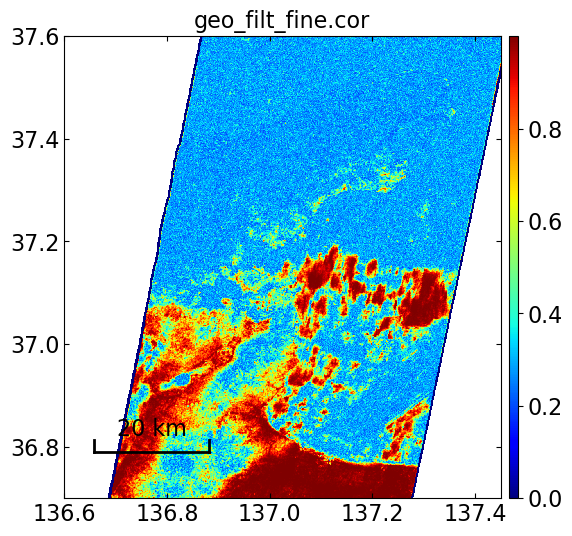

In [15]:
opt = f'-l {geom_file} --fill nan --bbox {S} {N} {W} {E} --lalo -{ystep_d} {xstep_d}'
io_files = [
    [int_file, './geo/geo_filt_fine.int'],
    [unw_file, './geo/geo_filt_fine.unw'],
    [cor_file, './geo/geo_filt_fine.cor'],
]

os.makedirs('./geo', exist_ok=True)
for ifile, ofile in io_files:
    if redo or not os.path.isfile(ofile):
        cmd = f'{ifile} -o {ofile} {opt}'
        print(f'geocode.py {cmd}')
        geocode.main(cmd.split())
        #meta['BANDS'] = 1
        writefile.write_isce_xml(meta, fname=ofile)

    # plot
    view.main(f'{ofile} --noverbose'.split())

### Plot

run view.py in MintPy version 1.6.0.post6, date 2024-05-20
input file is isce .int file: /panda/yunjunz/2024NotoEQ/ALOS2_D019_20211019_20240109/insar/geo/geo_filt_fine.int in complex64 format
file size in y/x: (1620, 1067)
input dataset: "['phase']"
num of datasets in file geo_filt_fine.int: 2
datasets to exclude (0):
[]
datasets to display (1):
['phase']
data   coverage in y/x: (0, 0, 1067, 1620)
subset coverage in y/x: (0, 0, 1067, 1620)
data   coverage in lat/lon: (136.6, 37.6, 137.44988553266154, 36.699999999999996)
subset coverage in lat/lon: (136.6, 37.6, 137.44988553266154, 36.699999999999996)
------------------------------------------------------------------------
colormap: cmy
initiate cartopy map projection: PlateCarree
figure title: ALOS2_D019_20211019_20240109_IFG
figure size : [7.1, 6.0]
reading data ...
masking pixels with zero value
data    range: [-3.1415794, 3.1415772] radian
display range: [-3.141592653589793, 3.141592653589793] radian
reading DEM: elevation.dem ...
d

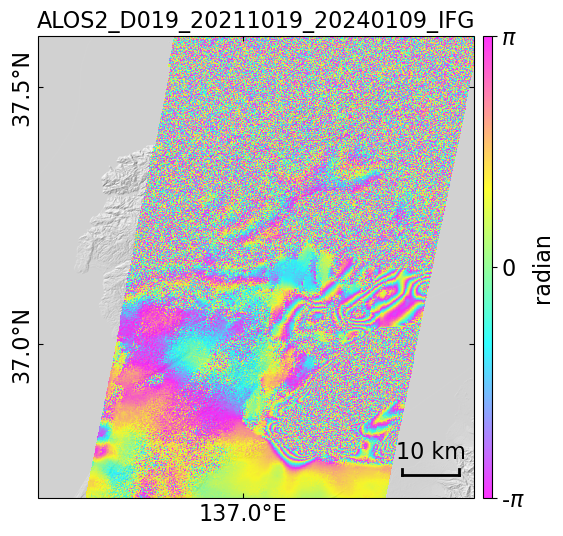

In [16]:
dem_file = os.path.join(proj_dir, 'DEM/elevation.dem')
out_file = os.path.join(proj_dir, f'notebooks/pic/{ds_name}.png')
cmd = f'./geo/geo_filt_fine.int phase --zero-mask --dem {dem_file} --dem-nocontour --shade-exag 0.05 '
cmd += f'--lalo-label --lalo-step 0.5 --scalebar 0.15 0.90 0.05 --title {ds_name} --ylabel-rot 90 -c cmy '
cmd += f'-o {out_file} '
view.main(cmd.split())